## Research Objective
To analyze how environmental and temporal factors influence crop yield and to estimate the relative contribution of rainfall, soil fertility, and long-term trends. A statistical regression model is then used to forecast near-term yield outcomes under assumed future conditions.

## This is the sample build of this project using pseudo data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from IPython.display import clear_output

### 1. Generating pseudo data and saving in : `data/pseudo_crop_daa.csv`

Locking the randomness of the data

In [2]:
np.random.seed(42)

Creating a data as 2010 2011 2012 ... 2024

In [3]:
years = np.arange(2010, 2025)

Generating random data following the normal distribution (bell shaped data)

In [4]:
rainfall_mm = np.random.normal(800, 60, len(years))

Generating random numbers and keeping them in constraints to make the data around real life (0.6 - 0.85)
- These values are a relative quality score of other factors :
    - nitrogen
    - moisture (and other factors)
> 0.6 means the land is 60% of **optimal fertility**

In [5]:
soil_index = np.clip(
    np.random.normal(0.72, 0.05, len(years)),
    0.6, 0.85
)

Crop yield is influenced by rainfall, soil fertility and other unpredictable factors.
- `2.5 * rainfall_mm` : (model assumption)
    - for every extra **1 mm of rainfall** Yield increase by about **2.5 kg/hectare** 
- `1800 * soil_index` : (1800 is a scaling factor)
    - A small change in soil quality can cause large yield difference 
- `.normal` : (mean = 0 , standard dev. = 120 *(120 kg/ha of difference)* , one value per year)
    - Adding noise : Pests , Disease outbreaks , Farmer practices , Market access , Seed quality , etc
    - Even with same rainfall and soil index the crop yield vary

In [6]:
crop_yield = (
    2.5 * rainfall_mm +
    1800 * soil_index +
    np.random.normal(0, 120, len(years))
)

Creating the table out of the model data

In [7]:
data = pd.DataFrame({
    "year": years,
    "rainfall_mm": rainfall_mm.round(0),
    "soil_index": soil_index.round(2),
    "crop_yield": crop_yield.round(0)
})


Saving to file : `data/pseudo_crop_data.csv`

In [8]:
data.to_csv("data/pseudo_crop_data.csv", index=False)
data

,year,rainfall_mm,soil_index,crop_yield
0,2010,830.0,0.69,3248.0
1,2011,792.0,0.67,3406.0
2,2012,839.0,0.74,3420.0
3,2013,891.0,0.67,3316.0
4,2014,786.0,0.65,3232.0
5,2015,786.0,0.79,3246.0
6,2016,895.0,0.71,3538.0
7,2017,846.0,0.72,3182.0
8,2018,772.0,0.65,2938.0
9,2019,833.0,0.69,3352.0


### 2. Loading the data from the file to our project to simulate real project.

In [9]:
df = pd.read_csv("data/pseudo_crop_data.csv")
df.head()

,year,rainfall_mm,soil_index,crop_yield
0,2010,830.0,0.69,3248.0
1,2011,792.0,0.67,3406.0
2,2012,839.0,0.74,3420.0
3,2013,891.0,0.67,3316.0
4,2014,786.0,0.65,3232.0


### Understanding the data pattern.

In [10]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         15 non-null     int64  
 1   rainfall_mm  15 non-null     float64
 2   soil_index   15 non-null     float64
 3   crop_yield   15 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 612.0 bytes


,year,rainfall_mm,soil_index,crop_yield
count,15.000000,15.000000,15.000000,15.000000
mean,2017.000000,800.733333,0.700667,3230.066667
std,4.472136,59.636358,0.039182,199.532835
min,2010.000000,685.000000,0.650000,2834.000000
25%,2013.500000,772.000000,0.670000,3162.500000
50%,2017.000000,792.000000,0.690000,3248.000000
75%,2020.500000,836.000000,0.725000,3352.000000
max,2024.000000,895.000000,0.790000,3538.000000


### 3. Creating simple graph out of our data to visualize it.

##### a) Yield vs Year :
Shows the yield of a crop in a particular year

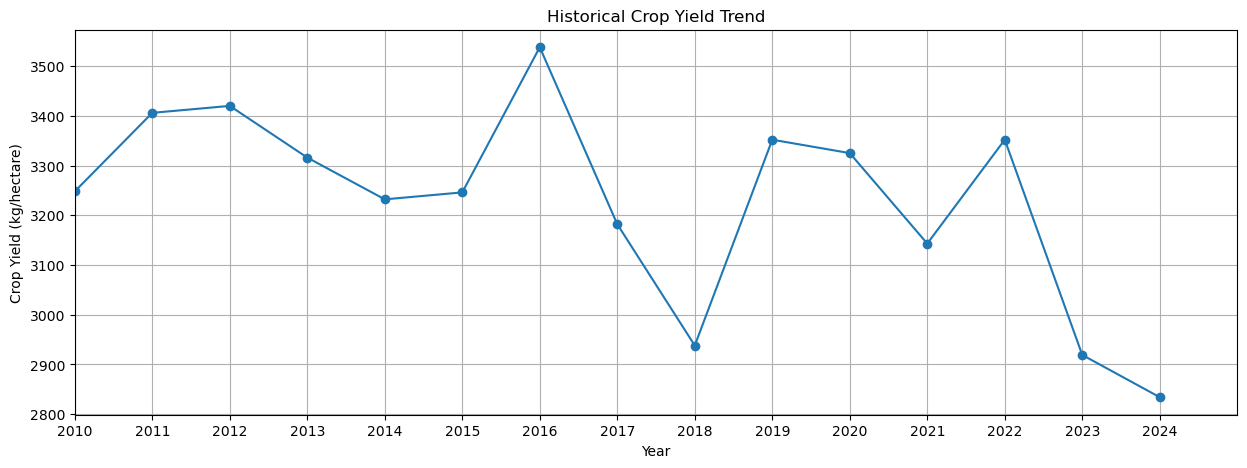

In [11]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2010, 2025))
plt.xlim(2010,2025)

plt.plot(df["year"], df["crop_yield"], marker="o")      # year on x , crop_yield on x , o at points
# label to understand
plt.xlabel("Year")
plt.ylabel("Crop Yield (kg/hectare)")                   
plt.title("Historical Crop Yield Trend")                
plt.grid(True)                
plt.show()                                              

##### b) Yield vs  Rainfall
- Scatter graph : 
    - higher rainfall means high yeld?
    - roughly linear?
    - amount noise?

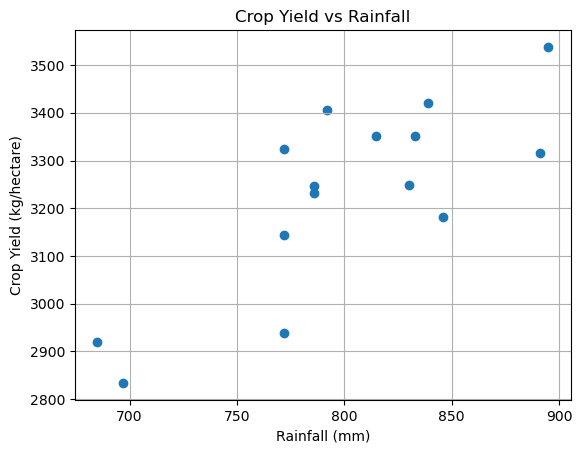

In [12]:
plt.scatter(df["rainfall_mm"], df["crop_yield"], marker="o")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Crop Yield (kg/hectare)")
plt.title("Crop Yield vs Rainfall")
plt.grid(True)
plt.show()

##### c) Yield vs Soil Index :
- Scatter graph : 
    - roughly linear or not?
    - amount noise?
    -

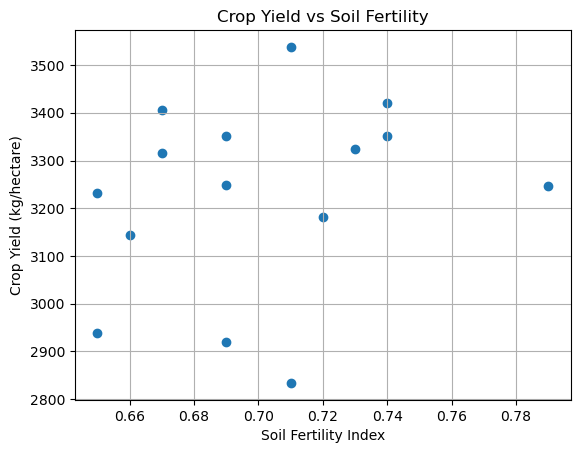

In [13]:
plt.scatter(df["soil_index"], df["crop_yield"],marker="o")
plt.xlabel("Soil Fertility Index")
plt.ylabel("Crop Yield (kg/hectare)")
plt.title("Crop Yield vs Soil Fertility")
plt.grid(True)
plt.show()

The soil–yield relationship appears more scattered because soil fertility varies within a narrow range, while yield is simultaneously influenced by rainfall and unobserved factors, masking the isolated soil effect.

### 4. Using simple linear regression to learn the stats.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

Defining variables:
- X : (independent/**explanatory** variable)
    - These are observed or assumed : not controlled _by_ the crop
- Y : (dependent/**response** variable)
    - The _outcome_ : result of environmental conditions.

In [15]:
X = df[["rainfall_mm", "soil_index", "year"]]
y = df["crop_yield"]

---

**MODEL 1 :** Learning relationship between : environmental conditions (x) and crop yield (Y)

`Crop yield = b0(yield) + b1(rainfall) + b2(soil) + b3(year)`
- Coefficients : how strongly doe each factor influence crop yield 
    - The estimated change in yield when one factor changes by one unit, **assuming others stay constant**

- `.fit`
    - summarizes the dominant direction in noisy data

In [16]:
model = LinearRegression()
model.fit(X, y)

coefficients = pd.DataFrame({
    "Factor": X.columns,
    "Impact_on_Yield": model.coef_
})

coefficients

,Factor,Impact_on_Yield
0,rainfall_mm,2.251423
1,soil_index,1091.551785
2,year,-7.629010


OUTPUT : 
- Rainfall coefficient : 2.25 
    - For every additional **1 mm** of annual rainfall, crop yield increase by ~2.25 kg/ha
    - *assuming soil fertility and long-term trends stay constant
- Soil Index coefficient : 1091.55
    - If soil fertility index increase by **1 full unit**, yield increase by ~1091kg/ha 
    - But **1 unit** change will never happen: (realistic change : 0.05)
        - 0.05 * 1091 = ~55kg/ha
- Year coefficient : -7.63 (_negative time trend_)
    - Even if rainfall and soil index are constant, yield decreases by ~7.6 kg/ha every year

This means : 
> Environmental support is being outweighed by long term stress > **Sustainability** is at risk

---

Function : 
- For each column : 
    - subtracts the mean
    - divides by standard deviation
- This makes each feature unitless :
    - This now measure **importance** instead of **scale**

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[["rainfall_mm", "soil_index", "year"]])

**MODEL 2 :** Learning relationship between **standardized environmental conditions (X_scaled) and crop yield (Y) in real units (_kg/ha_)

`yield = b0 + B1_Z(rainfall) + B2_Z(soil) + B3_Z(year)`

> Which factor matters more relative to its natural variability?

After standardization :
- +1 rainfall   : usually wet year
- +1 soil       : usually fertile soil
- +1 year       : one standard deviation into the future

> What happens to yield when given factor deviates from normal?

In [18]:
model = LinearRegression()
model.fit(X_scaled, y)

standardized_coeffs = pd.DataFrame({
    "Factor": ["Rainfall", "Soil Fertility", "Time"],
    "Standardized_Impact": model.coef_
})

standardized_coeffs

,Factor,Standardized_Impact
0,Rainfall,129.713925
1,Soil Fertility,41.319076
2,Time,-32.961091


OUTPUT : 
- Rainfall : + 129.7
    - When rainfall is significantly above or below normal, crop yield changes by **~130  kg/h**, holding other factors constant. 
    - Rainfall variability has the **strongest leverage effect**
- Soil Fertility : + 41.3
    - A one-standard-deviation improvement in soil health increase yield by **~41 kg/ha**
    - Soil varies slowly, it does not fluctuate wildly year to year
- Time : -33
    - Moving one standard deviation forward in time (several years), yield decreases by **~33 kg/ha**
    - Meaning :
        - there exists a systematic negative drift, not explained by measured environmental data

> Changes in rainfall have the biggest impact on crop yield, soil health also matters but to a lesser extent, and over time there appears to be a slow decline in yield that cannot be explained by rainfall or soil alone.

---

Converting raw data into understandable **percentage**
- Out of everything that affects yield, how much does each factor matter relative to the others?

In [19]:
standardized_coeffs["Absolute_Impact"] = standardized_coeffs["Standardized_Impact"].abs()
standardized_coeffs["Relative_Contribution (%)"] = (
    standardized_coeffs["Absolute_Impact"] / standardized_coeffs["Absolute_Impact"].sum() * 100
)

standardized_coeffs.sort_values(
    "Relative_Contribution (%)", ascending=False
)

,Factor,Standardized_Impact,Absolute_Impact,Relative_Contribution (%)
0,Rainfall,129.713925,129.713925,63.587099
1,Soil Fertility,41.319076,41.319076,20.255036
2,Time,-32.961091,32.961091,16.157866


OUTPUT :

rank | which factor | std impact | abs_impact | how much impact compared to other factors

Creating a graph to visualize it :

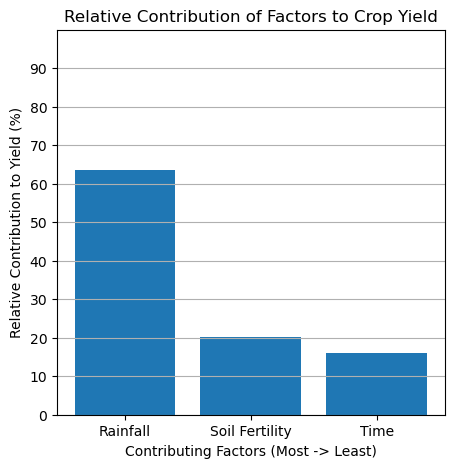

In [20]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 100)
plt.yticks(range(0, 100,10))

plt.bar(
    standardized_coeffs["Factor"],
    standardized_coeffs["Relative_Contribution (%)"]
)

plt.xlabel("Contributing Factors (Most -> Least)")
plt.ylabel("Relative Contribution to Yield (%)")
plt.title("Relative Contribution of Factors to Crop Yield")

plt.grid(axis="y")
plt.show()


---

### 5. Looking at the historical trends and Scaling then in future

#### a) Learn historical trends :

> On average how have rainfall and soil fertility changed over time in the past?

- Rainfall fluctuates yearly, but may have slow drifts,
- Soil fertility changes slowly and often monotonically.

`rainfall = ~ a*year + b` and `soil_index = ~ c.year + d`
- a,c = trends per year
- b,d = baseline levels

- Independent variable (year)

In [21]:
years_2d = df[["year"]]

- Rainfall trends

In [22]:
rain_trend_model = LinearRegression()
rain_trend_model.fit(years_2d, df["rainfall_mm"])

rain_slope = rain_trend_model.coef_[0]                  # average change in rainfall per year (mm/year)
rain_slope

np.float64(-7.999999999999998)

On average, rainfall has decreased by **8 mm** per year over the historical period.

- Soil fertility trend

In [23]:
soil_trend_model = LinearRegression()
soil_trend_model.fit(years_2d, df["soil_index"])

soil_slope = soil_trend_model.coef_[0]
soil_slope

np.float64(0.0007142857142857118)

On average, soil fertility index increased by ~0.0007 per year

- OUTPUT :
    - Positive slope : has been **increased** on average 
    - negative slope : has been **decreased** on average
    - Near zero      : no clear long-term trend

#### b) Baseline future from historical 

> Given what history has been doing on average, where does it naturally lead if nothing changes?

- Creating future years :

In [24]:
future_years = pd.DataFrame({
    "year": range(2025, 2031)
})


- Continuing the rainfall and soil trends

In [25]:
baseline_rainfall = rain_trend_model.predict(future_years)
baseline_soil = soil_trend_model.predict(future_years)

baseline_future = pd.DataFrame({
    "year": future_years["year"],
    "rainfall_mm": baseline_rainfall,
    "soil_index": baseline_soil
})

- Transforming our data to **scalar** data

In [26]:
baseline_scaled = scaler.transform(
    baseline_future[["rainfall_mm", "soil_index", "year"]]
)

- Using the scalar data to predict the yield

In [27]:
baseline_future["baseline_yield"] = model.predict(baseline_scaled)

> In year Y, if rainfall and soil continue following historical trends, the expected crop yield would be Z kg/ha.”

In [28]:
baseline_future

,year,rainfall_mm,soil_index,baseline_yield
0,2025,736.733333,0.706381,3031.180952
1,2026,728.733333,0.707095,3006.320238
2,2027,720.733333,0.707810,2981.459524
3,2028,712.733333,0.708524,2956.598810
4,2029,704.733333,0.709238,2931.738095
5,2030,696.733333,0.709952,2906.877381


##### b1) Modifying data to better visualization :

- Combining the columns of both the dataset (past - future)

In [29]:
combined = pd.concat([
    df[["year", "rainfall_mm", "soil_index", "crop_yield"]]
        .rename(columns={"crop_yield": "yield"}),
    baseline_future[["year", "rainfall_mm", "soil_index", "baseline_yield"]]
        .rename(columns={"baseline_yield": "yield"})
])

- Creating **Anomaly %** for visualization :
    - `Index = (value / mean) × 100`
    - `Anomaly (%) = ((value - mean) / mean) × 100`

This sets the normal value to the 0

In [30]:
combined["rainfall_anomaly_pct"] = (
    (combined["rainfall_mm"] - df["rainfall_mm"].mean())
    / df["rainfall_mm"].mean()
) * 100

combined["soil_anomaly_pct"] = (
    (combined["soil_index"] - df["soil_index"].mean())
    / df["soil_index"].mean()
) * 100

combined["yield_anomaly_pct"] = (
    (combined["yield"] - df["crop_yield"].mean())
    / df["crop_yield"].mean()
) * 100


- Creating the all in one graph to show trends and future
    - 0 : normal / historical average
    - -10 : 10% below normal
    - +10 : 10% above normal

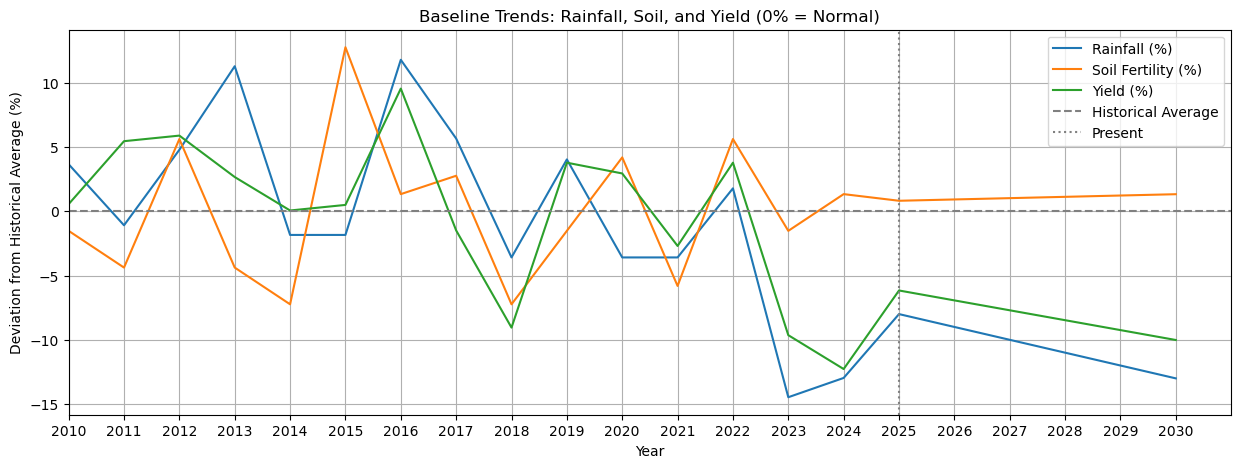

In [31]:
plt.figure(figsize=(15, 5))
plt.xlim(2010,2031)
plt.xticks(range(2010, 2031))

plt.plot(combined["year"], combined["rainfall_anomaly_pct"], label="Rainfall (%)")
plt.plot(combined["year"], combined["soil_anomaly_pct"], label="Soil Fertility (%)")
plt.plot(combined["year"], combined["yield_anomaly_pct"], label="Yield (%)")

plt.axhline(0, linestyle="--", color="gray", label="Historical Average")
plt.axvline(2025, linestyle=":", color="gray", label="Present")

plt.xlabel("Year")
plt.ylabel("Deviation from Historical Average (%)")
plt.title("Baseline Trends: Rainfall, Soil, and Yield (0% = Normal)")
plt.legend()
plt.grid(True)
plt.show()


---

In [32]:
def run_scenario(rain_pct=0.0, soil_pct=0.0): 
    
    # 1. Apply % deviation to baseline future 
    scenario_future = baseline_future.copy() 
    
    scenario_future["rainfall_mm"] = ( scenario_future["rainfall_mm"] * (1 + rain_pct) ) 
    
    scenario_future["soil_index"] = ( scenario_future["soil_index"] * (1 + soil_pct) ) 
    
    # 2. Scale inputs for the yield model 
    scenario_scaled = scaler.transform( scenario_future[["rainfall_mm", "soil_index", "year"]] ) 
    
    # 3. Predict yield 
    scenario_future["projected_yield"] = model.predict(scenario_scaled) 
    
    return scenario_future

In [33]:
# Baseline (0% rainfall, 0% soil) — fixed reference
baseline_scenario = run_scenario(
    rain_pct=0.0,
    soil_pct=0.0
)

In [34]:
def plot_scenario(rain_pct=0.0, soil_pct=0.0):

    scenario_future = run_scenario(
        rain_pct=rain_pct,
        soil_pct=soil_pct
    )

    plt.figure(figsize=(15, 5))
    plt.xlim(2010, 2031)
    plt.xticks(range(2010, 2031))

    plt.plot(
        df["year"],
        df["crop_yield"],
        label="Historical Yield",
        linewidth=2
    )

    plt.plot(
        baseline_scenario["year"],
        baseline_scenario["projected_yield"],
        linestyle="--",
        linewidth=2,
        label="Baseline Future Yield (0%)"
    )

    plt.plot(
        scenario_future["year"],
        scenario_future["projected_yield"],
        linestyle=":",
        linewidth=3,
        label=f"Scenario Yield (Rain {rain_pct:+.0%}, Soil {soil_pct:+.0%})"
    )

    plt.axvline(2025, linestyle=":", color="gray", label="Present")

    plt.xlabel("Year")
    plt.ylabel("Crop Yield (kg/hectare)")
    plt.title("Crop Yield Response to Rainfall & Soil Changes")
    plt.legend()
    plt.grid(True)

    plt.show()


In [35]:
interact(
    plot_scenario,
    rain_pct=FloatSlider(
        min=-1.0, max=1.0, step=0.05, value=0.0,
        description="Rainfall (%)"
    ),
    soil_pct=FloatSlider(
        min=-1.0, max=1.0, step=0.05, value=0.0,
        description="Soil (%)"
    )
)

interactive(children=(FloatSlider(value=0.0, description='Rainfall (%)', max=1.0, min=-1.0, step=0.05), FloatS…

<function __main__.plot_scenario(rain_pct=0.0, soil_pct=0.0)>

---

## Conclusion
The analysis indicates that crop yield is primarily influenced by rainfall variability, followed by soil fertility, with long-term temporal trends contributing comparatively less. Under assumed future conditions of declining rainfall and gradual soil degradation, the model forecasts a moderate decrease in crop yield over the next five years. These results highlight the importance of environmental management and adaptive agricultural practices to mitigate future yield risks.